<a href="https://colab.research.google.com/github/Herceg00/sphere_nn/blob/master/Task5/Lichmanov-Speedup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Личманов Дмитрий Игоревич

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import sys
from IPython.display import clear_output

def _epoch(network, loss, loader,
           backward=True,
           optimizer=None,
           device='cpu',
           ravel_init=False):
    losses = []
    accuracies = []
    for X, y in loader:
        X = X.to(device)
        y = y.to(device)
        if ravel_init:
            X = X.view(X.size(0), -1)
        network.zero_grad()
        prediction = network(X)
        loss_batch = loss(prediction, y)
        losses.append(loss_batch.cpu().item())
        if backward:
            loss_batch.backward()
            optimizer.step()
        prediction = prediction.max(1)[1]
        accuracies.append((prediction==y).cpu().float().numpy().mean())
    return losses, accuracies


def train(network, train_loader, test_loader,
          epochs, learning_rate, ravel_init=False,
          device='cpu', tolerate_keyboard_interrupt=True):
    loss = nn.NLLLoss()
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    network = network.to(device)
    try:
        for epoch in range(epochs):
            network.train()
            losses, accuracies = _epoch(network,
                                        loss,
                                        train_loader,
                                        True,
                                        optimizer,
                                        device,
                                        ravel_init)
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            
            network.eval()
            losses, accuracies = _epoch(network,
                                        loss,
                                        test_loader,
                                        False,
                                        optimizer,
                                        device,
                                        ravel_init)

            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            print('Epoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(train_loss_epochs, label='Train')
            plt.plot(test_loss_epochs, label='Test')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.subplot(1, 2, 2)
            plt.plot(train_accuracy_epochs, label='Train accuracy')
            plt.plot(test_accuracy_epochs, label='Test accuracy')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Accuracy', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.show()
    except KeyboardInterrupt:
        if tolerate_keyboard_interrupt:
            pass
        else:
            raise KeyboardInterrupt
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs


На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [3]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [4]:
images_train, labels_train = next(iter(train_loader))

In [5]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

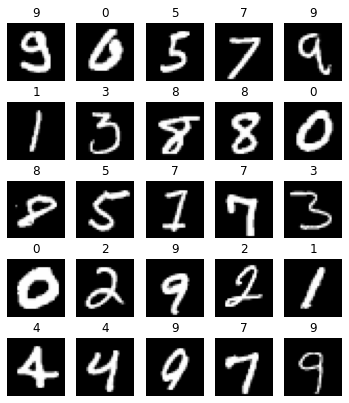

In [6]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [7]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    #1 - веса сети
    #2 - нули ...
    #bias = torch.zeros_like(bias)
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

    
# пример:
layer = nn.Linear(28*28, 10)
layer.register_forward_hook(forward_hook)
layer.register_backward_hook(backward_hook)
init_layer(layer, 0.0, 0.1) # сюда надо подставить другие параметры

In [8]:
sizes = [28*28, 64, 32] + [16] * 30 + [10]
layers = []

def normal(size_input, size_output):
    return 0.1
    #return 1

def xavier(size_input, size_output):
    d = 2 / (size_input + size_output)
    return np.sqrt(d)

def good_grad(size_input, size_output):
    d = 1 / size_output
    return np.sqrt(d)

# prior to data arrays 
def he_1(size_input, size_output):
    d = 2 / size_input
    return np.sqrt(d)

#prior to gradient arrays
def he_2(size_input, size_output):
    d = 2 / size_output
    return np.sqrt(d)


#init_func = normal
#init_func = xavier
#init_func = good_grad
init_func = he_2
#init_func = he_1

for size_input, size_output in zip(sizes, sizes[1:]):
    
    layer = nn.Linear(size_input, size_output)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_layer(layer, 0.0, init_func(size_input, size_output)) # сюда надо подставить другие параметры
    
    layers.append(layer)
    #layers.append(nn.Tanh())
    #layers.append(nn.Sigmoid())
    layers.append(nn.ReLU())
    
print(len(layers))
del layers[-1]
print(layers)

66
[Linear(in_features=784, out_features=64, bias=True), ReLU(), Linear(in_features=64, out_features=32, bias=True), ReLU(), Linear(in_features=32, out_features=16, bias=True), ReLU(), Linear(in_features=16, out_features=16, bias=True), ReLU(), Linear(in_features=16, out_features=16, bias=True), ReLU(), Linear(in_features=16, out_features=16, bias=True), ReLU(), Linear(in_features=16, out_features=16, bias=True), ReLU(), Linear(in_features=16, out_features=16, bias=True), ReLU(), Linear(in_features=16, out_features=16, bias=True), ReLU(), Linear(in_features=16, out_features=16, bias=True), ReLU(), Linear(in_features=16, out_features=16, bias=True), ReLU(), Linear(in_features=16, out_features=16, bias=True), ReLU(), Linear(in_features=16, out_features=16, bias=True), ReLU(), Linear(in_features=16, out_features=16, bias=True), ReLU(), Linear(in_features=16, out_features=16, bias=True), ReLU(), Linear(in_features=16, out_features=16, bias=True), ReLU(), Linear(in_features=16, out_features

<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [9]:
# Experiments with He_1
network = nn.Sequential(*layers)

#пример:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 1.0050793886184692
forward 3.060112953186035
forward 4.730133056640625
forward 8.667068481445312
forward 8.016066551208496
forward 6.816760063171387
forward 5.486443042755127
forward 6.791735649108887
forward 6.118978023529053
forward 7.3174567222595215
forward 7.006229400634766
forward 6.184718608856201
forward 8.38171100616455
forward 9.26630687713623
forward 6.815715789794922
forward 6.576708793640137
forward 9.973727226257324
forward 5.758727550506592
forward 5.181211948394775
forward 6.196343898773193
forward 7.882256507873535
forward 7.512872695922852
forward 6.748673439025879
forward 5.762128829956055
forward 6.54185152053833
forward 7.1718292236328125
forward 5.361464977264404
forward 6.043659687042236
forward 3.322951078414917
forward 3.658665657043457
forward 3.5044405460357666
forward 4.001815319061279
forward 2.7851767539978027
backward 0.030184611678123474
backward 0.08260094374418259
backward 0.08310870826244354
backward 0.04709428548812866
backward 0.062897875905

<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

In [10]:
# Experiments with He_2
network = nn.Sequential(*layers)

#пример:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 1.0050793886184692
forward 3.060112953186035
forward 4.730133056640625
forward 8.667068481445312
forward 8.016066551208496
forward 6.816760063171387
forward 5.486443042755127
forward 6.791735649108887
forward 6.118978023529053
forward 7.3174567222595215
forward 7.006229400634766
forward 6.184718608856201
forward 8.38171100616455
forward 9.26630687713623
forward 6.815715789794922
forward 6.576708793640137
forward 9.973727226257324
forward 5.758727550506592
forward 5.181211948394775
forward 6.196343898773193
forward 7.882256507873535
forward 7.512872695922852
forward 6.748673439025879
forward 5.762128829956055
forward 6.54185152053833
forward 7.1718292236328125
forward 5.361464977264404
forward 6.043659687042236
forward 3.322951078414917
forward 3.658665657043457
forward 3.5044405460357666
forward 4.001815319061279
forward 2.7851767539978027
backward 0.030184611678123474
backward 0.08260094374418259
backward 0.08310870826244354
backward 0.04709428548812866
backward 0.062897875905

<i> 1.4 Сделайте выводы по первой части </i>

Как и ожидалось, сеть с активациями ReLU будет хорошо обучаться при "He" инициализации. Лучше показала себя инициализация He_1 - более ровные результаты, если сравнивать forward prop и backward prop. He_2 даст чуть более дальние от 0 градиенты, но дисперсия входов будет больше.


### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [11]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):    
        mask = torch.zeros_like(self.linear.weight) + self.p
        if self.training:          
            mask = mask.bernoulli()
        mask = mask.data
        output = F.linear(x, self.linear.weight * mask, self.linear.bias)
        return output

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями 
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

In [12]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()    
        
        channels = 1
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),    
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),            
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        
        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()
        
        self.final_part = final_part
        print("final part: ", final_part)
        
        self.log_softmax = nn.LogSoftmax(1)        
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

###Clear


In [13]:
sizes = [196, 256, 128, 10]
layers = []
for size_input, size_output in zip(sizes, sizes[1:]):
    layer = nn.Linear(size_input, size_output)   
    layers.append(layer)
    layers.append(nn.ReLU())

del layers[-1]

In [14]:
print(*layers)

Linear(in_features=196, out_features=256, bias=True) ReLU() Linear(in_features=256, out_features=128, bias=True) ReLU() Linear(in_features=128, out_features=10, bias=True)


Epoch 9... (Train/Test) NLL: 0.067/0.076	Accuracy: 0.979/0.976


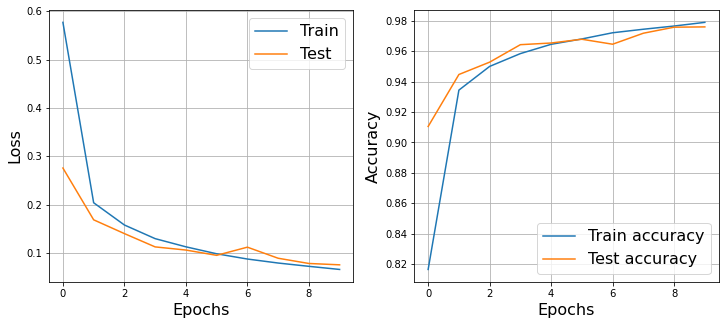

CPU times: user 3min 27s, sys: 3.14 s, total: 3min 31s
Wall time: 3min 31s


In [15]:
%%time


network = TestNetwork(nn.Sequential(*layers))
train(network, train_loader, test_loader, 10, 0.001, device='cpu')

Переобучаемся:(

###DropConnect

In [16]:
sizes = [196, 256, 128, 10]
layers = []
for size_input, size_output in zip(sizes, sizes[1:]):
    layer = DropConnect(size_input, size_output, 0.9)
    layers.append(layer)
    layers.append(nn.ReLU())

del layers[-1]

In [17]:
print(*layers)

DropConnect(
  (linear): Linear(in_features=196, out_features=256, bias=True)
) ReLU() DropConnect(
  (linear): Linear(in_features=256, out_features=128, bias=True)
) ReLU() DropConnect(
  (linear): Linear(in_features=128, out_features=10, bias=True)
)


Epoch 9... (Train/Test) NLL: 0.050/0.057	Accuracy: 0.983/0.983


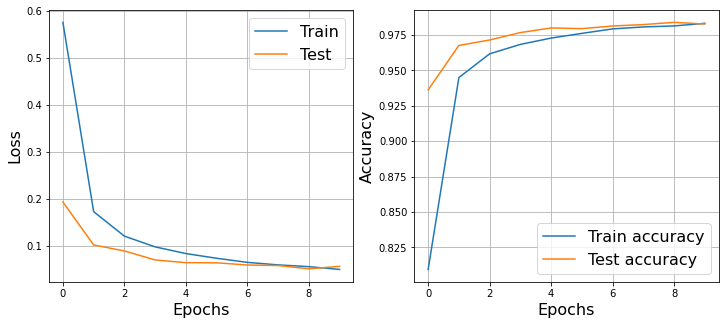

CPU times: user 3min 34s, sys: 3.79 s, total: 3min 38s
Wall time: 3min 38s


In [18]:
%%time

#dropconnect

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001, device='cpu')

Переобучения меньше(появилось только на 8-9 эпохе), точность чуть выше


###DropOut

In [19]:
sizes = [196, 256, 128, 10]
layers = []
for size_input, size_output in zip(sizes, sizes[1:]):
    layer = nn.Linear(size_input, size_output)    
    layers.append(layer)
    layers.append(nn.ReLU())
    layers.append(nn.Dropout(0.5))

del layers[-2:]

In [20]:
print(*layers)

Linear(in_features=196, out_features=256, bias=True) ReLU() Dropout(p=0.5, inplace=False) Linear(in_features=256, out_features=128, bias=True) ReLU() Dropout(p=0.5, inplace=False) Linear(in_features=128, out_features=10, bias=True)


Epoch 9... (Train/Test) NLL: 0.101/0.075	Accuracy: 0.969/0.978


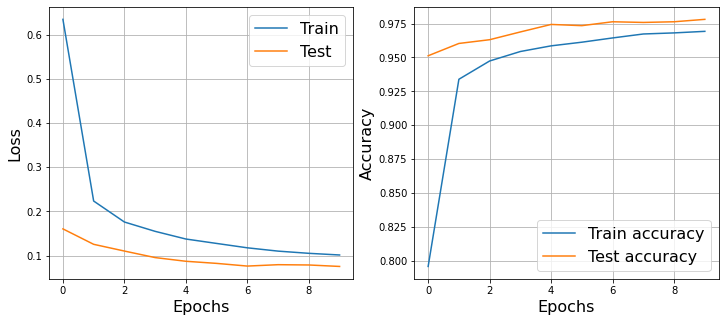

CPU times: user 3min 27s, sys: 3.69 s, total: 3min 31s
Wall time: 3min 31s


In [21]:
%%time

#dropout

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001, device='cpu')

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

<i> 2.3 Сделайте выводы по третьей части. </i>

Dropout продемонстрировал чуть более плохой результат

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [22]:
# полезные функции: .std(dim), .mean(dim)
# "ширина" датасета - всегда последняя размерность, этим и пользуемся
class LayerNormalization(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.gamma = nn.Parameter(torch.FloatTensor(input_size).fill_(0.5), requires_grad=True)
        self.betta = nn.Parameter(torch.FloatTensor(input_size).fill_(0.1), requires_grad=True) 

    def forward(self, x):
        eps = 1e-6
        layer_std = x.std(dim=-1,keepdim=True)
        layer_mean = x.mean(dim=-1, keepdim=True) 
        output = ((x-layer_mean) / (layer_std+eps))*self.gamma + self.betta
        return output

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Batch normalization между всеми слоями 
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

In [23]:
sizes = [196, 128, 128, 10]
layers = []
for size_input, size_output in zip(sizes, sizes[1:]):
    layer = nn.Linear(size_input, size_output)
    layers.append(layer)
    layers.append(LayerNormalization(size_output))
    layers.append(nn.ReLU())

del layers[-2:]

Epoch 9... (Train/Test) NLL: 0.029/0.072	Accuracy: 0.991/0.979


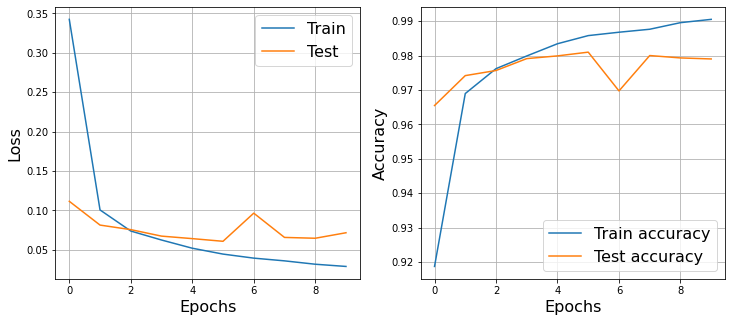

([0.34248559481140645,
  0.10063110928990439,
  0.0738737783444398,
  0.06247151843202648,
  0.052063608420953186,
  0.04461589389677241,
  0.039481282151286316,
  0.03602906146686453,
  0.03174609646572471,
  0.028933654171424603],
 [0.11160292438691176,
  0.08142788365153195,
  0.07564714184337401,
  0.0674126680138745,
  0.0642400461402309,
  0.060851171455063115,
  0.09655419463008831,
  0.06576584090914907,
  0.06470975241788864,
  0.07169439277521046],
 [0.91869336,
  0.9689721,
  0.9762127,
  0.9799052,
  0.9834588,
  0.9858242,
  0.98680705,
  0.9876732,
  0.98958886,
  0.9905495],
 [0.9654865,
  0.9741891,
  0.9756725,
  0.9791337,
  0.97992486,
  0.98101264,
  0.9697389,
  0.98002374,
  0.9793315,
  0.9790348])

In [24]:
network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001, device='cpu')

In [25]:
sizes = [196, 128, 128, 10]
layers = []
for size_input, size_output in zip(sizes, sizes[1:]):
    layer = nn.Linear(size_input, size_output)
    layers.append(layer)
    layers.append(nn.BatchNorm1d(size_output))
    layers.append(nn.ReLU())

del layers[-2:]

Epoch 9... (Train/Test) NLL: 0.019/0.054	Accuracy: 0.994/0.983


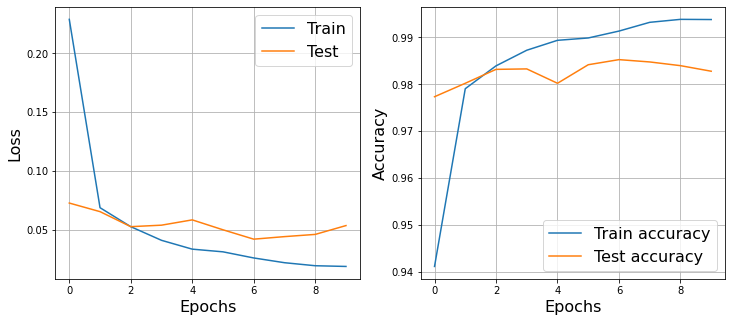

([0.2290016352725245,
  0.06871838677031145,
  0.052563367165259715,
  0.04095118078015951,
  0.03344069885512961,
  0.0311571176566962,
  0.025943796890579275,
  0.02190601974025742,
  0.019331894998651133,
  0.0187245184890561],
 [0.07267082087648442,
  0.06536529347583463,
  0.05257778281133763,
  0.05384732000647655,
  0.058354372759880146,
  0.04991140731984655,
  0.04194087999625296,
  0.044104184690108406,
  0.04599094877160991,
  0.05350455597243449],
 [0.94116473,
  0.97906667,
  0.98393637,
  0.9872679,
  0.98938346,
  0.9898832,
  0.9913546,
  0.99322027,
  0.9938533,
  0.9938144],
 [0.97735363,
  0.9802215,
  0.9831883,
  0.98328716,
  0.9802215,
  0.98417723,
  0.985265,
  0.9847706,
  0.9839794,
  0.98279274])

In [26]:
network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001, device='cpu')

<i> 3.3 Сделайте выводы по третьей части </i>

Переобучение на нормализации высоковато, но скор на тесте от этого не уменьшился

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару:

Немного смутила фраза, что batch norm вычисляется независимо для каждого нейрона. Именно наличие слова "нейрон". Но разобрался.